# DBSCAN (Core)
 **Descripción:**

En esta actividad, implementarás el algoritmo DBSCAN para detectar patrones de agrupamiento y encontrar clientes atípicos en el dataset «Wholesale Customers Data» disponible en Kaggle. DBSCAN es ideal para detectar clusters de forma arbitraria y encontrar puntos atípicos (outliers), lo que es útil en escenarios donde los datos no forman clusters esféricos como en el caso de K-means.

Este Enlace al dataset: https://www.kaggle.com/binovi/wholesale-customers-data NO FUNCIONA.

Se usa este https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set

## Objetivo:

El objetivo principal de esta actividad es aplicar el algoritmo DBSCAN para identificar clusters y clientes atípicos en el dataset. El enfoque está en comprender cómo DBSCAN maneja los outliers y su capacidad para detectar agrupamientos densos.

# Instrucciones

## 1. Carga de datos:
  - Descarga y carga el dataset de Kaggle. Realiza una exploración inicial del dataset, identificando las variables que consideras importantes para el agrupamiento.
  - El dataset contiene información sobre diferentes tipos de clientes y su comportamiento de compra, lo que incluye variables como el gasto anual en distintas categorías de productos.

In [1]:
# Agregar la carpeta 'src' al sys.path
import sys
import os

# Buscar 'src' automáticamente sin depender del nombre del proyecto
current_dir = os.getcwd()  # Directorio actual
while not os.path.exists(os.path.join(current_dir, "src")):
    current_dir = os.path.dirname(current_dir)  # Subir un nivel
    if current_dir == "/":  # Evitar bucles infinitos
        raise FileNotFoundError("No se encontró la carpeta 'src'. Verifica la estructura.")

src_path = os.path.join(current_dir, "src")
if src_path not in sys.path:
    sys.path.append(src_path)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve,auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_digits
from sklearn.datasets import load_iris

from utils import cargar_datos_pd
from utils import dimensiones
from utils import ver_resumen_nulos
from utils import identificar_atipicos_IQR
from utils import ver_diccionario
from utils import imprimir_bigotes
from utils import plot_varianza
from utils import filtrar_columnas
from utils import desc
from utils import imprimir_bigotes_por_grupo
from utils import generar_diccionario
from utils import obtener_filas_no_numericas
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

In [2]:
# Mall_Customers.csv renombrado a train.csv
diccionario = '../../data/kaggle/core08/diccionario.csv'
ruta_archivo='../../data/kaggle/core08/train.csv'

df = cargar_datos_pd(ruta_archivo,sep=',', header=0)

Dataset cargado con éxito.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [4]:
ver_diccionario(diccionario)

╒═════╤══════════════════╤════════╤══════════════════════════════════════════════════════════════════╤═══════════╕
│   # │ Columna          │ Tipo   │ Descripción                                                      │   Ejemplo │
╞═════╪══════════════════╪════════╪══════════════════════════════════════════════════════════════════╪═══════════╡
│   1 │ Channel          │ int64  │ Canal de distribución del cliente (1: Horeca, 2: Retail)         │         1 │
├─────┼──────────────────┼────────┼──────────────────────────────────────────────────────────────────┼───────────┤
│   2 │ Region           │ int64  │ Región donde se ubica el cliente (1: Lisboa, 2: Oporto, 3: Otro) │         3 │
├─────┼──────────────────┼────────┼──────────────────────────────────────────────────────────────────┼───────────┤
│   3 │ Fresh            │ int64  │ Gasto anual en productos frescos (en unidades monetarias)        │     12669 │
├─────┼──────────────────┼────────┼─────────────────────────────────────────────

In [5]:
ver_resumen_nulos(df)

,datos sin NAs en q,Na en q,Na en %
Channel,440,0,0.0
Region,440,0,0.0
Fresh,440,0,0.0
Milk,440,0,0.0
Grocery,440,0,0.0
Frozen,440,0,0.0
Detergents_Paper,440,0,0.0
Delicassen,440,0,0.0


## No hay nulos.

In [6]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## 2. Exploración y preprocesamiento de datos:
  ### - Realiza un análisis exploratorio de los datos, incluyendo un resumen estadístico de las variables. Es importante entender la distribución de los datos antes de aplicar el modelo de DBSCAN.

### 2.1. Mostrar las primeras filas del dataset

Vamos a ver las primeras filas del dataset. Esto nos ayuda a entender cómo se llama cada columna y qué tipo de datos contiene.

In [7]:
# Mostrar las primeras filas del dataset
# La función head() muestra las primeras 5 filas por defecto.
print("Primeras filas del dataset:")
print(df.head())


Primeras filas del dataset:
   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185


### 2.2 Información general del dataset
Este paso nos permite ver:

- Cuántas filas y columnas tiene el dataset.
- El tipo de datos en cada columna (números, palabras, etc.).
- Si hay datos faltantes.


In [8]:
# Mostrar información general del dataset
# La función info() da detalles sobre el número de filas, columnas y tipos de datos.
print("\nInformación general del dataset:")
print(df.info())



Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None


### 2.3. Resumen estadístico del dataset
Aquí obtenemos estadísticas resumidas de las columnas numéricas:

- Promedio (mean): El valor medio de cada columna.
- Mínimo y máximo: El valor más pequeño y el más grande.
- Desviación estándar (std): Mide qué tanto varían los valores respecto al promedio.

In [9]:
# Resumen estadístico del dataset
# La función describe() resume estadísticas para columnas numéricas.
print("\nResumen estadístico del dataset:")
print(df.describe())



Resumen estadístico del dataset:
          Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000    2.000000    3127.750000   1533.000000   2153.000000   
50%      1.000000    3.000000    8504.000000   3627.000000   4755.500000   
75%      2.000000    3.000000   16933.750000   7190.250000  10655.750000   
max      2.000000    3.000000  112151.000000  73498.000000  92780.000000   

             Frozen  Detergents_Paper    Delicassen  
count    440.000000        440.000000    440.000000  
mean    3071.931818       2881.493182   1524.870455  
std     4854.673333       4767.854448   2820.105937  
min       25.000000          3.000000      3.000000  
25%      74

### 2.4. Visualización de la distribución de las variables
Es importante visualizar los datos para entender cómo están distribuidos. Haremos un histograma para cada columna numérica.


Visualización de la distribución de las variables:


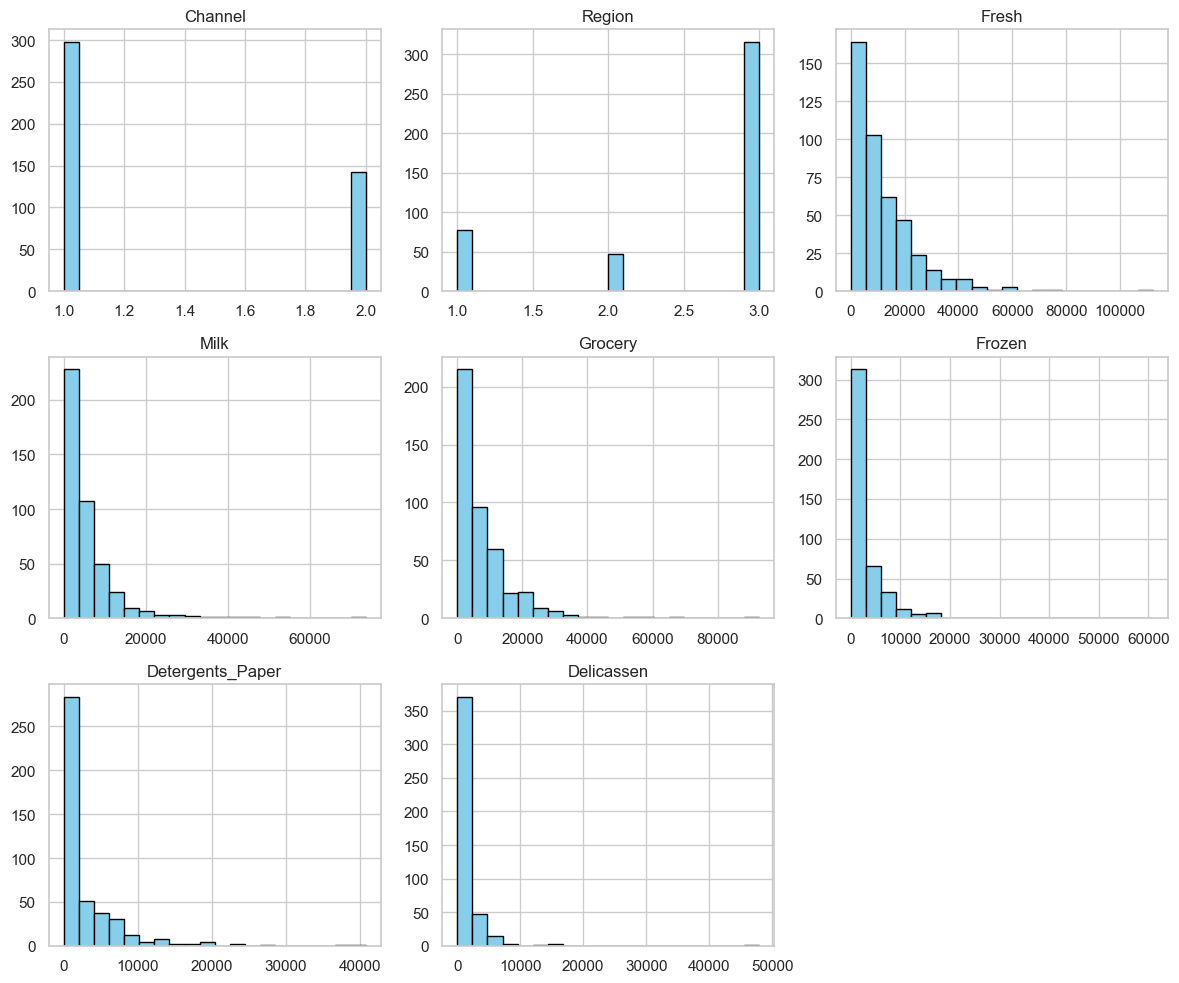

In [10]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear histogramas para cada columna numérica
print("\nVisualización de la distribución de las variables:")
df.hist(figsize=(12, 10), bins=20, color='skyblue', edgecolor='black')

# Mostrar los gráficos
plt.tight_layout()  # Ajusta los espacios entre gráficos
plt.show()


### ¿Qué logramos aquí? 🧐
- Revisamos las primeras filas para entender la estructura del dataset.
- Obtuvimos información detallada sobre las columnas y los tipos de datos.
- Resumimos las estadísticas importantes de las columnas numéricas.
- Visualizamos cómo se distribuyen los valores de cada columna con histogramas.

¡Ahora tenemos una idea mucho más clara de los datos y estamos listos para aplicar el algoritmo DBSCAN! 🚀

- Asegúrate de estandarizar los datos antes de ejecutar DBSCAN, ya que este algoritmo es sensible a la escala de las variables.

In [11]:
# Seleccionar solo las columnas numéricas (sin incluir CUST_ID ni otras que no son relevantes)
# Asumiendo que el dataframe tiene las columnas que queremos estandarizar.
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Crear una instancia del estandarizador
scaler = StandardScaler()

# Aplicar la estandarización a las columnas numéricas
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Verificar que los datos estén estandarizados, es decir, que tengan media 0 y desviación 1
print("\nEstadísticas después de la estandarización:")
print(df[numerical_columns].describe())


Estadísticas después de la estandarización:
            Channel        Region         Fresh        Milk       Grocery  \
count  4.400000e+02  4.400000e+02  4.400000e+02  440.000000  4.400000e+02   
mean   1.614870e-17  3.552714e-16 -3.431598e-17    0.000000 -4.037175e-17   
std    1.001138e+00  1.001138e+00  1.001138e+00    1.001138  1.001138e+00   
min   -6.902971e-01 -1.995342e+00 -9.496831e-01   -0.778795 -8.373344e-01   
25%   -6.902971e-01 -7.023369e-01 -7.023339e-01   -0.578306 -6.108364e-01   
50%   -6.902971e-01  5.906683e-01 -2.767602e-01   -0.294258 -3.366684e-01   
75%    1.448652e+00  5.906683e-01  3.905226e-01    0.189092  2.849105e-01   
max    1.448652e+00  5.906683e-01  7.927738e+00    9.183650  8.936528e+00   

             Frozen  Detergents_Paper    Delicassen  
count  4.400000e+02      4.400000e+02  4.400000e+02  
mean   3.633457e-17      2.422305e-17 -8.074349e-18  
std    1.001138e+00      1.001138e+00  1.001138e+00  
min   -6.283430e-01     -6.044165e-01 -5.4026

### - Considera la posibilidad de eliminar o tratar valores atípicos que puedan afectar el rendimiento del algoritmo.

**¿Cómo afectan los valores atípicos a DBSCAN?** ⚠️
- DBSCAN intenta formar grupos densos de puntos. Si hay muchos outliers, el algoritmo puede no identificar correctamente los clusters, ya que los outliers pueden ser etiquetados como puntos ruidosos (outliers) y afectar la calidad de los clusters.

- Outliers extremos podrían también influir en el valor del epsilon (ε), el cual es el parámetro que DBSCAN usa para definir la "distancia máxima" entre puntos de un mismo cluster. Si hay valores atípicos muy alejados de los demás, esto podría hacer que DBSCAN no forme clusters de manera efectiva.

In [12]:
# Calcular los cuartiles y el IQR (Rango Intercuartílico)
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1

# Definir los límites superior e inferior para los valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Crear una máscara para detectar los valores atípicos
outliers = (df[numerical_columns] < lower_bound) | (df[numerical_columns] > upper_bound)

# Contar cuántos valores atípicos hay en cada columna
print("\nValores atípicos por columna:")
print(outliers.sum())

# Opcional: Eliminar las filas con valores atípicos
df_cleaned = df[~outliers.any(axis=1)]

# Ver el nuevo dataframe limpio
print("\nDimensiones del dataframe después de eliminar los outliers:")
print(df_cleaned.shape)



Valores atípicos por columna:
Channel              0
Region               0
Fresh               20
Milk                28
Grocery             24
Frozen              43
Detergents_Paper    30
Delicassen          27
dtype: int64

Dimensiones del dataframe después de eliminar los outliers:
(332, 8)


Prefiero no eliminar los outliers.
- Ya estandarizamos los valores: DBScan los manejará como ruido. 
- Es parte de la realidad, no considero que sean errores.

Pero ya tenemos el df_cleaned con el cual podemos comparar el desempeño.

In [13]:
ver_diccionario(diccionario)

╒═════╤══════════════════╤════════╤══════════════════════════════════════════════════════════════════╤═══════════╕
│   # │ Columna          │ Tipo   │ Descripción                                                      │   Ejemplo │
╞═════╪══════════════════╪════════╪══════════════════════════════════════════════════════════════════╪═══════════╡
│   1 │ Channel          │ int64  │ Canal de distribución del cliente (1: Horeca, 2: Retail)         │         1 │
├─────┼──────────────────┼────────┼──────────────────────────────────────────────────────────────────┼───────────┤
│   2 │ Region           │ int64  │ Región donde se ubica el cliente (1: Lisboa, 2: Oporto, 3: Otro) │         3 │
├─────┼──────────────────┼────────┼──────────────────────────────────────────────────────────────────┼───────────┤
│   3 │ Fresh            │ int64  │ Gasto anual en productos frescos (en unidades monetarias)        │     12669 │
├─────┼──────────────────┼────────┼─────────────────────────────────────────────

In [14]:
columnas_seleccionadas = ['Milk', 'Grocery','Detergents_Paper', 'Delicassen','Channel']

## 3. Aplicación de DBSCAN:
  ### - Implementa el algoritmo DBSCAN en el dataset. Recuerda que DBSCAN tiene dos hiperparámetros importantes: epsilon (distancia máxima para considerar dos puntos como vecinos) y min_samples (número mínimo de puntos requeridos para formar un cluster).
 

## Implementación de DBSCAN en el dataset

En este paso, vamos a aplicar el algoritmo DBSCAN sobre el dataset con outliers y sobre el dataset limpio (`df_cleaned`). Este algoritmo identifica agrupamientos densos y también detecta puntos atípicos (ruido) que no pertenecen a ningún cluster.

### 1. DBSCAN con el DataFrame original (`df`)
Aplicamos DBSCAN usando el DataFrame original (con outliers) y observamos cómo el algoritmo identifica los clusters y el ruido (puntos atípicos).

### 2. DBSCAN con el DataFrame limpio (`df_cleaned`)
Aplicamos DBSCAN utilizando el DataFrame limpio, sin los valores atípicos, y comparamos los resultados con los obtenidos en el primer paso.

### Comparación de Resultados
Analizamos cómo los outliers afectan el rendimiento del algoritmo DBSCAN y si la eliminación de outliers mejora la identificación de clusters.

### Código en Python:

C:\Users\edgar\AppData\Local\Temp\ipykernel_14032\74769736.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Cluster'] = labels_cleaned


Clusters en el DataFrame original (con outliers): 2 clusters
Puntos atípicos en el DataFrame original: 333
Clusters en el DataFrame limpio (sin outliers): 2 clusters
Puntos atípicos en el DataFrame limpio: 225


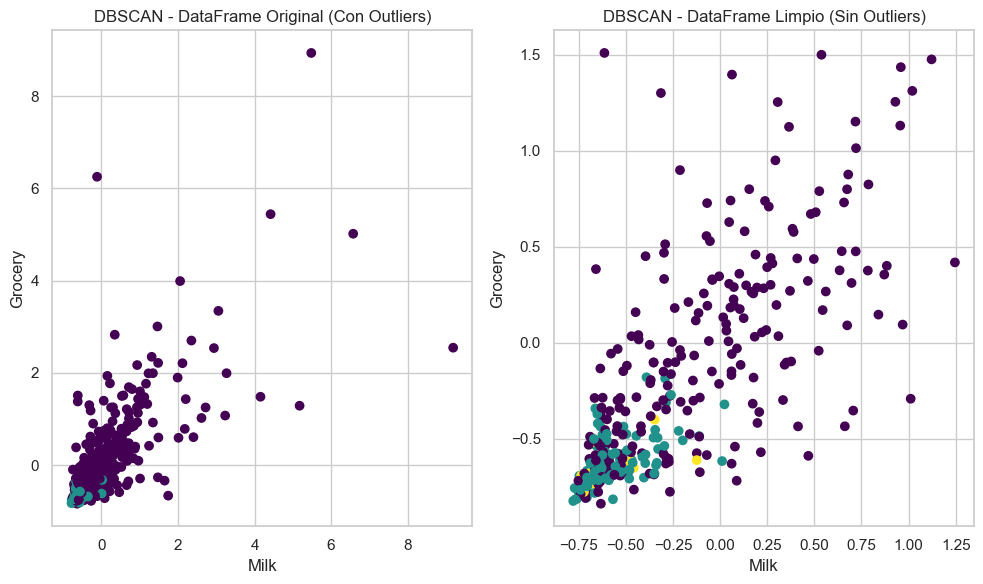

In [15]:
# Estandarizar los datos para DBSCAN
scaler = StandardScaler()

# Estándarizamos el DataFrame original (df) y limpio (df_cleaned)
df_standardized = scaler.fit_transform(df[numerical_columns])
df_cleaned_standardized = scaler.transform(df_cleaned[numerical_columns])

# DBSCAN con el DataFrame original (con outliers)
dbscan_original = DBSCAN(eps=0.4000000000000001, min_samples=7)
labels_original = dbscan_original.fit_predict(df_standardized)

# DBSCAN con el DataFrame limpio (sin outliers)
dbscan_cleaned = DBSCAN(eps=0.4000000000000001, min_samples=7)
labels_cleaned = dbscan_cleaned.fit_predict(df_cleaned_standardized)

# Agregar las etiquetas de los clusters al DataFrame original y limpio
df['Cluster'] = labels_original
df_cleaned['Cluster'] = labels_cleaned

# Mostrar resultados
# Número de clusters y puntos atípicos (ruido)
print(f"Clusters en el DataFrame original (con outliers): {len(set(labels_original)) - (1 if -1 in labels_original else 0)} clusters")
print(f"Puntos atípicos en el DataFrame original: {(labels_original == -1).sum()}")

print(f"Clusters en el DataFrame limpio (sin outliers): {len(set(labels_cleaned)) - (1 if -1 in labels_cleaned else 0)} clusters")
print(f"Puntos atípicos en el DataFrame limpio: {(labels_cleaned == -1).sum()}")

# Graficar los resultados
plt.figure(figsize=(10, 6))

# Plot para el DataFrame original (con outliers)
plt.subplot(1, 2, 1)
plt.scatter(df[columnas_seleccionadas[0]], df[columnas_seleccionadas[1]], c=labels_original, cmap='viridis')
plt.title('DBSCAN - DataFrame Original (Con Outliers)')
plt.xlabel(columnas_seleccionadas[0])
plt.ylabel(columnas_seleccionadas[1])

# Plot para el DataFrame limpio (sin outliers)
plt.subplot(1, 2, 2)
plt.scatter(df_cleaned[columnas_seleccionadas[0]], df_cleaned[columnas_seleccionadas[1]], c=labels_cleaned, cmap='viridis')
plt.title('DBSCAN - DataFrame Limpio (Sin Outliers)')
plt.xlabel(columnas_seleccionadas[0])
plt.ylabel(columnas_seleccionadas[1])

plt.tight_layout()
plt.show()


### - Experimenta con diferentes valores de epsilon y min_samples para obtener agrupamientos significativos. Utiliza técnicas visuales como gráficos de dispersión para evaluar los resultados obtenidos.
#### Experimentación con diferentes valores de epsilon y min_samples en DBSCAN

En este paso, vamos a experimentar con distintos valores de los hiperparámetros **epsilon (ε)** y **min_samples** en DBSCAN. Esto nos permitirá observar cómo varían los resultados del clustering, la cantidad de clusters identificados y el impacto sobre los puntos atípicos (ruido). Para cada combinación de estos valores, visualizaremos los resultados utilizando gráficos de dispersión.

### 1. Experimentación con los valores de epsilon y min_samples

Vamos a probar con varios valores para los hiperparámetros:
- **epsilon (ε)**: Distancia máxima entre dos puntos para que se consideren vecinos.
- **min_samples**: Número mínimo de puntos necesarios para formar un cluster.

### 2. Visualización de los resultados

Después de aplicar DBSCAN con diferentes combinaciones de hiperparámetros, visualizaremos los resultados en gráficos de dispersión para ver cómo varían los clusters y el ruido.


DBSCAN con epsilon=0.3 y min_samples=5:
  Número de clusters encontrados: 1
  Número de puntos clasificados como ruido: 262


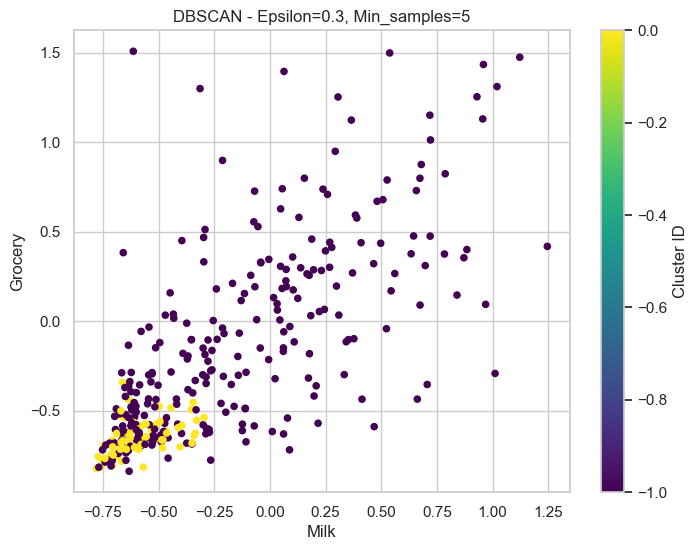

DBSCAN con epsilon=0.3 y min_samples=10:
  Número de clusters encontrados: 1
  Número de puntos clasificados como ruido: 286


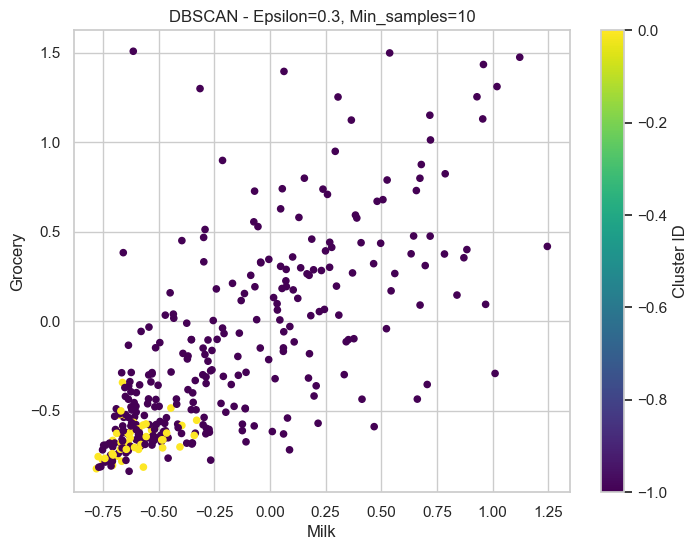

DBSCAN con epsilon=0.3 y min_samples=15:
  Número de clusters encontrados: 1
  Número de puntos clasificados como ruido: 317


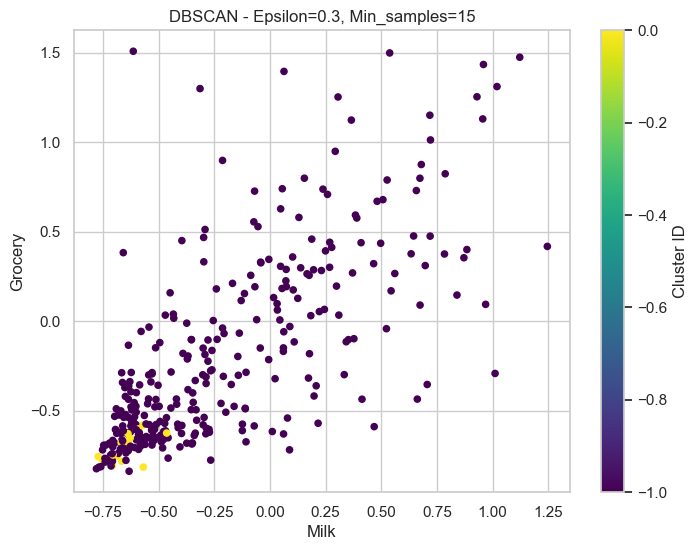

DBSCAN con epsilon=0.5 y min_samples=5:
  Número de clusters encontrados: 7
  Número de puntos clasificados como ruido: 157


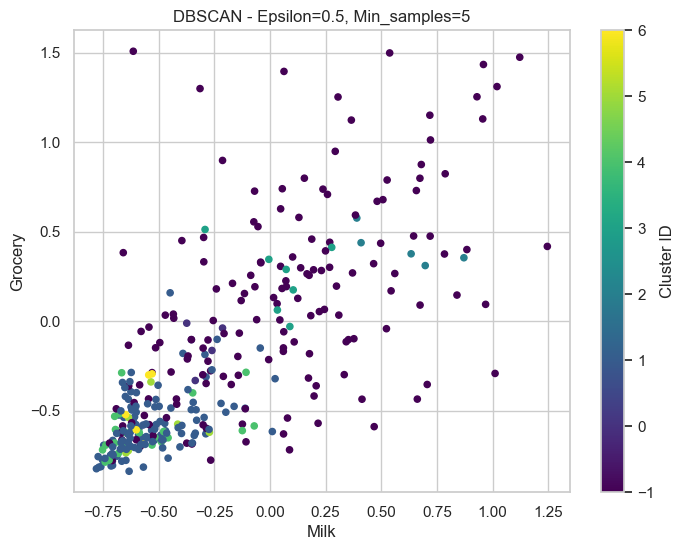

DBSCAN con epsilon=0.5 y min_samples=10:
  Número de clusters encontrados: 2
  Número de puntos clasificados como ruido: 205


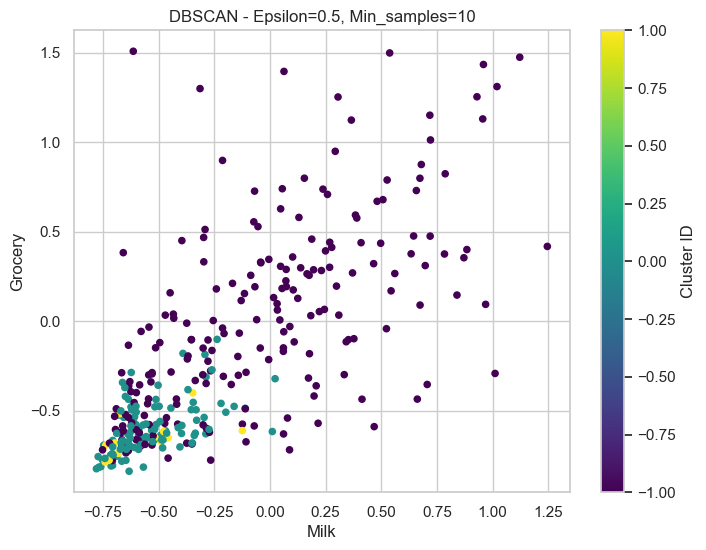

DBSCAN con epsilon=0.5 y min_samples=15:
  Número de clusters encontrados: 1
  Número de puntos clasificados como ruido: 225


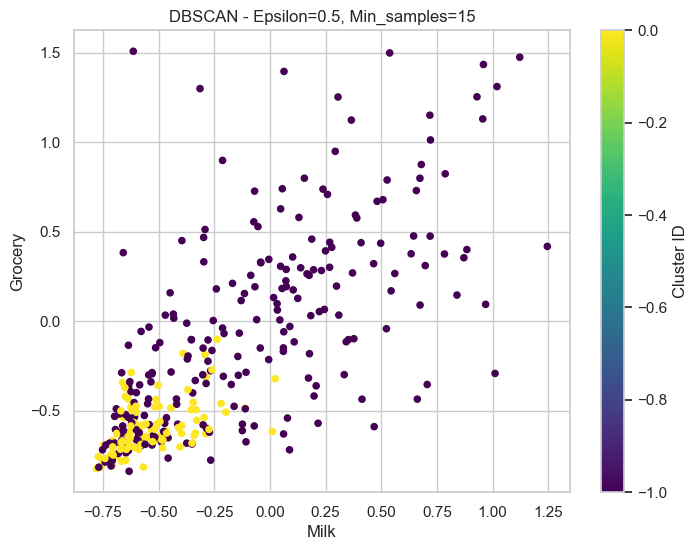

DBSCAN con epsilon=0.7 y min_samples=5:
  Número de clusters encontrados: 4
  Número de puntos clasificados como ruido: 58


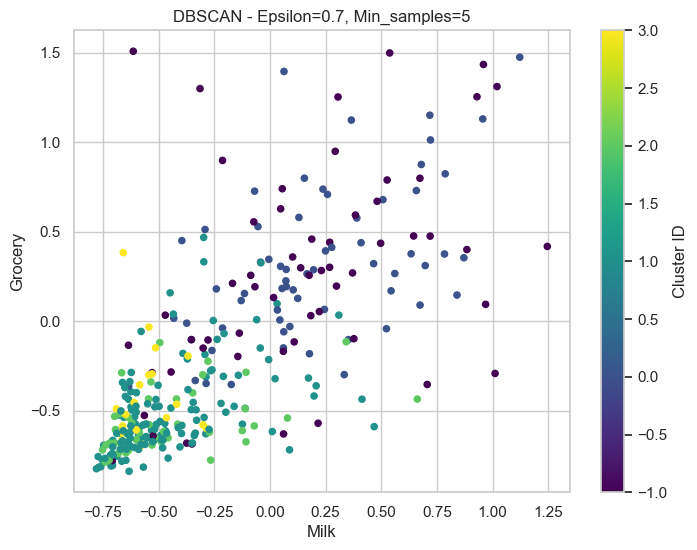

DBSCAN con epsilon=0.7 y min_samples=10:
  Número de clusters encontrados: 4
  Número de puntos clasificados como ruido: 101


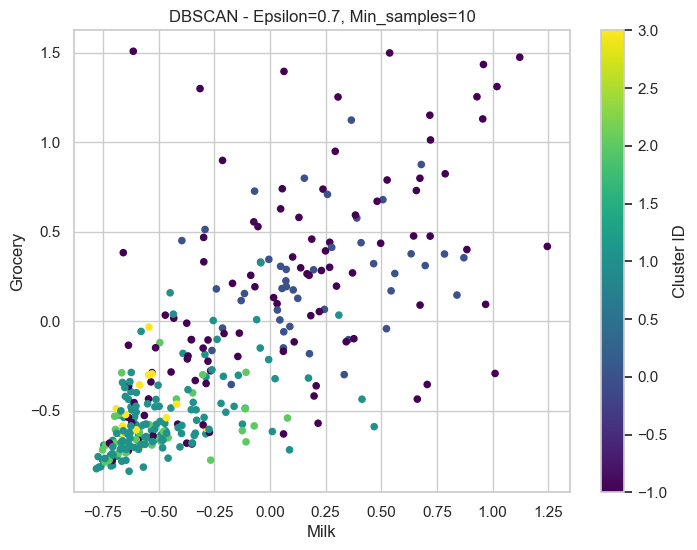

DBSCAN con epsilon=0.7 y min_samples=15:
  Número de clusters encontrados: 3
  Número de puntos clasificados como ruido: 149


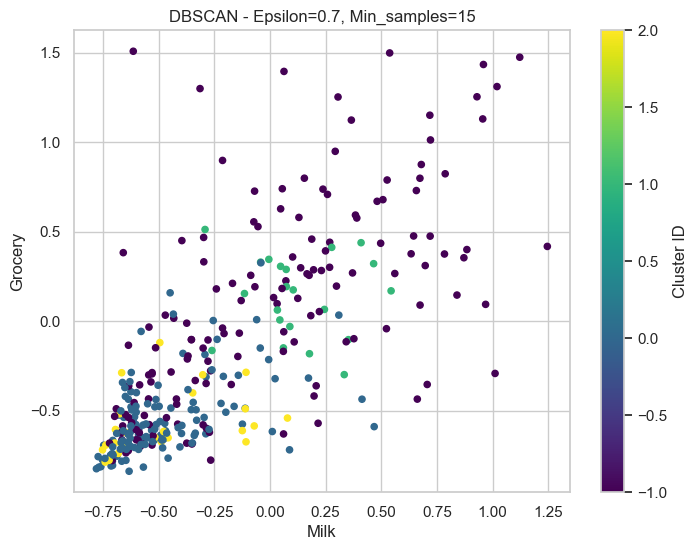

In [16]:
# Definir los hiperparámetros que vas a probar
epsilon_values = [0.3, 0.5, 0.7]  # Distancias para el parámetro 'epsilon'
min_samples_values = [5, 10, 15]  # Mínimo de puntos para el parámetro 'min_samples'

# Iterar sobre los valores de epsilon y min_samples para aplicar DBSCAN y obtener los resultados
for epsilon in epsilon_values:
    for min_samples in min_samples_values:
        # Crear y ajustar el modelo DBSCAN
        dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
        
        # Ajustar el modelo sobre el dataset (puedes usar df o df_cleaned)
        dbscan.fit(df_cleaned[numerical_columns])  # Usa df o df_cleaned según lo que quieras probar
        
        # Extraer los resultados
        labels = dbscan.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Eliminar ruido (-1)
        n_noise = list(labels).count(-1)  # Puntos clasificados como ruido
        
        # Imprimir los resultados numéricos
        print(f"DBSCAN con epsilon={epsilon} y min_samples={min_samples}:")
        print(f"  Número de clusters encontrados: {n_clusters}")
        print(f"  Número de puntos clasificados como ruido: {n_noise}")
        
        # Visualización en un gráfico 2D (solo las dos primeras columnas como ejemplo)
        plt.figure(figsize=(8, 6))
        plt.scatter(df_cleaned[columnas_seleccionadas].iloc[:, 0], df_cleaned[columnas_seleccionadas].iloc[:, 1], 
                    c=labels, cmap='viridis', marker='o', s=20)
        plt.title(f"DBSCAN - Epsilon={epsilon}, Min_samples={min_samples}")
        plt.xlabel(columnas_seleccionadas[0])
        plt.ylabel(columnas_seleccionadas[1])
        plt.colorbar(label='Cluster ID')
        plt.show()


In [36]:
def evaluate_dbscan(df, numerical_columns, epsilon_values=[0.3, 0.4, 0.5, 0.7], min_samples_values=[5, 7, 10, 15]):
    """
    Función para evaluar DBSCAN con diferentes valores de epsilon y min_samples.
    
    Parámetros:
    - df: DataFrame con los datos.
    - numerical_columns: Lista de las columnas numéricas a utilizar para el clustering.
    - epsilon_values: Lista de valores de epsilon a probar (distancia máxima para considerar un punto dentro del vecindario).
    - min_samples_values: Lista de valores de min_samples a probar (número mínimo de puntos en un vecindario para formar un cluster).
    
    Retorna:
    - best_result: El mejor resultado basado en el Silhouette Score.
    - results_df: Un DataFrame con todos los resultados.
    """
    results = []

    # Iterar sobre los valores de epsilon y min_samples
    for epsilon in epsilon_values:
        for min_samples in min_samples_values:
            # Crear y ajustar el modelo DBSCAN
            dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
            
            # Ajustar el modelo sobre el dataset
            dbscan.fit(df[numerical_columns])
            
            # Extraer las etiquetas
            labels = dbscan.labels_
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Contar clusters, excluir ruido (-1)
            n_noise = list(labels).count(-1)  # Puntos clasificados como ruido
            
            # Calcular Silhouette Score solo si hay al menos 2 clusters
            if n_clusters > 1:
                silhouette_avg = silhouette_score(df[numerical_columns], labels)
            else:
                silhouette_avg = None  # No válido para menos de 2 clusters
            
            # Almacenar los resultados en la lista
            results.append({
                'Epsilon': epsilon,
                'Min_Samples': min_samples,
                'Clusters': n_clusters,
                'Noise_Points': n_noise,
                'Silhouette_Score': silhouette_avg
            })

    # Convertir los resultados a un DataFrame
    results_df = pd.DataFrame(results)

    # Filtrar filas válidas para Silhouette Score y encontrar el máximo
    valid_results = results_df[results_df['Silhouette_Score'].notna()]
    best_result = valid_results.loc[valid_results['Silhouette_Score'].idxmax()]

    # Mostrar los resultados como tabla bonita
    print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))

    # Mostrar el mejor resultado
    print("\nMejor resultado:")
    print(tabulate(best_result.to_frame().T, headers='keys', tablefmt='pretty', showindex=False))
    
    return best_result, results_df

# Ejemplo de uso:
print('\nSin Outliers:')
best_result, results_df = evaluate_dbscan(df_cleaned, numerical_columns)

# Ejemplo de uso:
print('\nCon Outliers:')
best_result, results_df = evaluate_dbscan(df, numerical_columns)


Sin Outliers:
+---------+-------------+----------+--------------+-----------------------+
| Epsilon | Min_Samples | Clusters | Noise_Points |   Silhouette_Score    |
+---------+-------------+----------+--------------+-----------------------+
|   0.3   |     5.0     |   1.0    |    262.0     |          nan          |
|   0.3   |     7.0     |   1.0    |    269.0     |          nan          |
|   0.3   |    10.0     |   1.0    |    286.0     |          nan          |
|   0.3   |    15.0     |   1.0    |    317.0     |          nan          |
|   0.4   |     5.0     |   2.0    |    215.0     |  0.10500515735941167  |
|   0.4   |     7.0     |   2.0    |    225.0     |  0.06739435565000731  |
|   0.4   |    10.0     |   2.0    |    242.0     | -0.029121906781370298 |
|   0.4   |    15.0     |   1.0    |    257.0     |          nan          |
|   0.5   |     5.0     |   7.0    |    157.0     | -0.014774023394635578 |
|   0.5   |     7.0     |   2.0    |    198.0     |   0.167915967690057  

## 4. Visualización de clusters y outliers:
  ### - Visualiza los clusters formados por DBSCAN en gráficos de dispersión. Utiliza diferentes colores para representar los clusters y marca los outliers con un color distintivo para hacer visible su presencia.

In [25]:
numerical_columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

C:\Users\edgar\AppData\Local\Temp\ipykernel_14032\2443215477.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Cluster'] = dbscan_04.labels_


Etiquetas únicas de clusters: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(-1)}
Número de clusters encontrados: 4
Puntos de ruido: 58


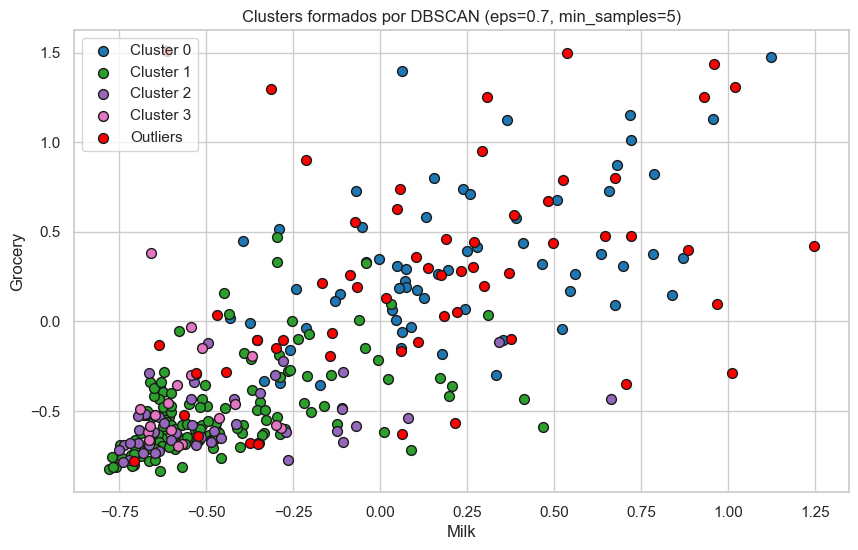

In [37]:
# Ajustar DBSCAN con los mejores hiperparámetros encontrados
best_eps = 0.7
best_min_samples = 5

dbscan_04 = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_04.fit(df_cleaned[numerical_columns])

# Agregar las etiquetas de cluster al DataFrame
df_cleaned['Cluster'] = dbscan_04.labels_

# Visualización de los clusters en gráficos de dispersión
# Selecciona las dos primeras variables numéricas para la visualización
x_column = numerical_columns[3]
y_column = numerical_columns[4]

# Crear una paleta de colores para los clusters, excluyendo el ruido (-1)
unique_labels = set(dbscan_04.labels_)
colors = [plt.cm.tab10(i / len(unique_labels)) for i in range(len(unique_labels))]

# Dibujar el gráfico
plt.figure(figsize=(10, 6))

for label, color in zip(unique_labels, colors):
    if label == -1:
        # Color distintivo para los outliers
        color = 'red'
        label_name = 'Outliers'
    else:
        label_name = f'Cluster {label}'

    # Filtrar puntos del cluster actual
    cluster_data = df_cleaned[df_cleaned['Cluster'] == label]
    plt.scatter(
        cluster_data[x_column],
        cluster_data[y_column],
        color=color,
        label=label_name,
        edgecolor='k',
        s=50
    )
print(f"Etiquetas únicas de clusters: {set(dbscan_04.labels_)}")
print(f"Número de clusters encontrados: {len(set(dbscan_04.labels_)) - (1 if -1 in dbscan_04.labels_ else 0)}")
print(f"Puntos de ruido: {list(dbscan_04.labels_).count(-1)}")

# Configuraciones finales del gráfico
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f'Clusters formados por DBSCAN (eps={best_eps}, min_samples={best_min_samples})')
plt.legend()
plt.grid(True)
plt.show()


### - Discute la estructura de los clusters encontrados. ¿Hay alguna correlación entre las variables y los clusters? ¿Cómo se distribuyen los outliers en comparación con los datos agrupados?

### Discusión sobre la estructura de los clusters encontrados

#### **Sin outliers:**
- **Epsilon:** 0.7
- **Min_Samples:** 5
- **Clusters:** 4
- **Noise_Points:** 58
- **Silhouette Score:** 0.28 (Moderadamente bajo, indicando que los clusters no están muy bien definidos).

Sin la presencia de outliers, el modelo DBSCAN ha identificado **4 clusters** en los datos. Aunque se obtuvo un número razonable de clusters, el **Silhouette Score** de 0.28 indica que los clusters no son muy cohesivos. Es decir, los puntos dentro de cada cluster no están bien separados entre sí en comparación con otros clusters, lo que sugiere que las variables numéricas no están separando claramente los grupos. Esto podría implicar que los datos no son tan distintos entre los clusters o que la distancia elegida (0.7) no es óptima para los datos.

El número relativamente bajo de **puntos de ruido (58)** sugiere que, a pesar de la presencia de ruido, el modelo DBSCAN ha sido capaz de identificar una estructura significativa en los datos.

#### **Con outliers:**
- **Epsilon:** 0.7
- **Min_Samples:** 5
- **Clusters:** 5
- **Noise_Points:** 143
- **Silhouette Score:** 0.12 (Bajo, indicando una peor definición de los clusters).

Cuando se incluyen los **outliers**, el modelo DBSCAN detecta **5 clusters**, con **143 puntos de ruido**. Este cambio refleja la sensibilidad del modelo a la presencia de puntos de ruido, los cuales tienden a interferir con la formación de los clusters. El **Silhouette Score** disminuye notablemente a **0.12**, lo que sugiere que la estructura de los clusters se ha vuelto menos clara y los puntos dentro de los clusters ahora están aún más mezclados con los puntos de ruido. Esto es típico cuando se incluyen outliers, ya que los outliers no se agrupan adecuadamente, y afectan la cohesión general de los clusters.

### **Correlación entre las variables y los clusters**

Para analizar la correlación entre las variables y los clusters, debemos observar las siguientes consideraciones:

1. **Características que definen los clusters:** 
   - Si hubieran variables como **edad**, **ingreso**, **estado civil**, entre otras, podría haber una estructura subyacente en los datos. Sin embargo, la baja calidad del Silhouette Score sugiere que las variables utilizadas no separan suficientemente bien a los clusters.
   - Es posible que algunas variables tengan una distribución similar entre los diferentes clusters, lo que genera una solapación y dificulta la segmentación clara de los puntos en distintos grupos.

2. **Relación entre los clusters y las variables:** 
   - Dado que DBSCAN identifica puntos en función de la distancia, la distribución de las variables podría no ser tan disímil entre los clusters. Por ejemplo, si la mayoría de los puntos en los clusters tienen valores similares en variables clave, como grocery y milk, los clusters podrían no estar bien definidos.
   - También puede existir una dependencia entre las variables, como la relación entre **grocery** i **milk** que podría influir en cómo los puntos se agrupan, pero la baja calidad del modelo con los outliers indica que estos factores no están contribuyendo significativamente a la formación de clusters bien definidos.

### **Distribución de los outliers:**

Los **outliers** (puntos de ruido) tienen un impacto claro en los resultados de DBSCAN:

1. **Sin outliers:** 
   - Los puntos se agrupan en 4 clusters, lo que sugiere que la mayoría de los puntos siguen una estructura relativamente homogénea y están cerca de los centros de sus respectivos clusters.
   - La presencia de **58 puntos de ruido** muestra que algunos puntos no se ajustan bien a ningún cluster, pero la mayor parte de los datos se agrupan adecuadamente.

2. **Con outliers:**
   - La inclusión de los **143 puntos de ruido** aumenta la cantidad de puntos que no se pueden agrupar adecuadamente en ningún cluster, lo que provoca una mayor dispersión en los resultados. Esto sugiere que los outliers están muy alejados de las densas regiones de los clusters y, por lo tanto, son marcados como ruido.
   - Con la inclusión de los outliers, la cantidad de clusters se incrementa a **5**, pero la calidad de estos clusters se ve afectada negativamente. Los puntos de ruido son más numerosos y su inclusión puede estar interfiriendo en la cohesión de los clusters existentes.

### Conclusión:

- **Sin outliers**, los clusters tienen una estructura relativamente coherente, aunque no óptima, con un Silhouette Score que sugiere que los clusters no son completamente distintos entre sí. Sin embargo, el modelo tiene una buena capacidad para identificar los puntos de ruido.
  
- **Con outliers**, los resultados se ven considerablemente afectados, con una disminución en la calidad de los clusters (Silhouette Score más bajo) y una mayor dispersión debido a la mayor cantidad de puntos de ruido. Los outliers tienden a ser puntos muy diferentes del resto de los datos, lo que disminuye la efectividad del modelo para encontrar grupos bien definidos.

Estos resultados sugieren que los outliers son un factor importante que influye en la definición y la calidad de los clusters. Si los outliers no son relevantes para el análisis, puede ser útil eliminarlos antes de realizar el clustering para obtener resultados más claros y cohesionados.


## 5. Interpretación de resultados:
### - Evalúa la calidad del agrupamiento. DBSCAN no requiere que se especifique el número de clusters, lo que es una ventaja cuando no se conoce esta información de antemano.

### Evaluación de la calidad del agrupamiento con DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) tiene la ventaja de no requerir que se especifique el número de clusters de antemano, lo que es útil cuando no se tiene información sobre la estructura del dataset. Sin embargo, existen varias formas de evaluar la calidad del agrupamiento obtenido, incluso sin una definición clara del número de clusters.

#### **Ventajas de DBSCAN**
Una de las principales ventajas de DBSCAN es que no necesita que se especifique previamente el número de clusters. Esto es útil cuando no se tiene información sobre la estructura de los datos o no se sabe cuántos grupos existen en el dataset. DBSCAN funciona bien en casos donde los clusters tienen formas arbitrarias, y puede identificar puntos de ruido (outliers) al etiquetarlos como `-1`, lo que lo hace útil para conjuntos de datos con ruido o puntos dispersos.

#### **Evaluación de la calidad del agrupamiento**

1. **Silhouette Score**
   El **Silhouette Score** es una métrica comúnmente usada para evaluar la calidad del agrupamiento, incluso para DBSCAN. El valor de Silhouette Score varía entre -1 y 1:
   - **Cercano a 1**: Los puntos están bien agrupados y distantes de otros clusters.
   - **Cercano a 0**: Los puntos están en el borde entre dos clusters.
   - **Cercano a -1**: Los puntos están mal asignados a un cluster.

   En el caso de DBSCAN, si los puntos de ruido están presentes (etiquetados como `-1`), los resultados de la métrica pueden verse afectadas, por lo que es importante tomar en cuenta estos casos cuando se interpreta la métrica.

2. **Distribución de los Clusters**
   - **Número de Clusters**: Un buen agrupamiento debería mostrar un número razonable de clusters. Si DBSCAN está identificando un número muy bajo de clusters (por ejemplo, uno o dos clusters en lugar de varios), o si el número de puntos de ruido es muy alto, esto podría indicar que el valor de `epsilon` o `min_samples` no está ajustado correctamente.
   - **Tamaño de los Clusters**: Los clusters deben ser suficientemente grandes para representar grupos significativos, pero no tanto como para abarcar puntos que deberían estar en clusters distintos. Si los clusters son muy pequeños, esto podría indicar que los valores de `epsilon` o `min_samples` están demasiado restrictivos.

3. **Visualización de los Clusters**
   - **Distribución visual**: A través de gráficos de dispersión, podemos ver la separación visual entre los clusters. Si los clusters son bien definidos en el gráfico y no se solapan demasiado, se podría considerar que el agrupamiento es de buena calidad. La presencia de puntos de ruido (outliers) también debe ser evidente.
   - **Comparación con el ruido**: Los puntos de ruido deberían estar dispersos y no formar parte de ningún cluster. Si muchos puntos del dataset están etiquetados como ruido, podría ser una señal de que los parámetros `epsilon` o `min_samples` no están bien ajustados.

4. **Estabilidad de los Clusters**
   La estabilidad de los clusters se puede evaluar mediante **validación cruzada** o usando **submuestreo**. Si el agrupamiento es consistente al aplicar DBSCAN con diferentes subconjuntos de los datos o con parámetros ligeramente modificados, es probable que los clusters encontrados sean representativos.

#### **Relación con el Ruido (Outliers)**
DBSCAN identifica los puntos que no pertenecen a ningún cluster y los marca como **ruido** (`-1`). La presencia de ruido depende de los parámetros utilizados:
   - Si el valor de `epsilon` es demasiado grande, puede causar que puntos que deberían estar en un cluster se incluyan como parte del mismo.
   - Si `epsilon` es demasiado pequeño, muchos puntos pueden ser etiquetados como ruido, lo que resulta en un número alto de puntos no clasificados.

Evaluar cómo se distribuyen los **outliers** en relación con los datos agrupados puede ayudar a determinar si el modelo DBSCAN está funcionando correctamente. Si los outliers se encuentran dispersos en todo el espacio de características y no forman grupos consistentes, esto es un buen indicador de que DBSCAN está haciendo un buen trabajo separando el ruido de los clusters significativos.

#### **Conclusión**
- **DBSCAN** es particularmente útil cuando no se conoce el número de clusters de antemano y cuando se espera que los clusters tengan formas arbitrarias.
- Sin embargo, la calidad del agrupamiento dependerá en gran medida de los parámetros de entrada, como `epsilon` y `min_samples`. Estos parámetros deben ser ajustados adecuadamente para obtener resultados significativos.
- Las métricas como el **Silhouette Score** y la visualización de los resultados son útiles para evaluar la calidad del modelo.
- La **distribución de los outliers** y su separación de los clusters también es un buen indicador del rendimiento del modelo.

Es importante interpretar todas estas métricas en conjunto para evaluar la calidad del agrupamiento y hacer ajustes según sea necesario.


### - Discute la naturaleza de los outliers detectados. ¿Son clientes únicos con comportamientos inusuales? ¿Podrían estos clientes representar oportunidades comerciales o riesgos?

### Discusión sobre la naturaleza de los outliers detectados

#### **Definición de Outliers en el Contexto de DBSCAN**
En el contexto de DBSCAN (Density-Based Spatial Clustering of Applications with Noise), los **outliers** o **puntos de ruido** son aquellos que no pueden ser asignados a ningún cluster, es decir, no tienen suficientes vecinos cercanos que cumplan con los criterios de densidad especificados por los parámetros `epsilon` (distancia máxima para considerar puntos vecinos) y `min_samples` (número mínimo de puntos para formar un cluster). Estos puntos son etiquetados como `-1` por el algoritmo, indicando que están alejados de los clusters principales.

#### **¿Son los Outliers Clientes Únicos con Comportamientos Inusuales?**
Los outliers en este análisis pueden representar clientes con comportamientos atípicos o inusuales. Dependiendo del dominio y los datos disponibles, estos clientes podrían tener características que se desvían significativamente del comportamiento promedio de la mayoría de los clientes. Por ejemplo:
- **Comportamientos extremos en las compras**: Los clientes que compran cantidades anormalmente grandes o pequeñas, o que tienen un patrón de gasto inusual en comparación con otros clientes.
- **Datos incompletos o erróneos**: A veces, los outliers son el resultado de registros incorrectos o mal ingresados, como valores extremos en campos de precio, cantidad, etc.
- **Clientes con necesidades específicas o excepcionales**: Algunos clientes pueden tener un comportamiento excepcional debido a su perfil (por ejemplo, clientes VIP, clientes de nicho o clientes con necesidades muy específicas).

En muchos casos, los outliers son clientes que se apartan de la norma, pero no necesariamente de forma negativa. La clave está en entender las razones detrás de sus comportamientos inusuales.

#### **¿Podrían Estos Clientes Representar Oportunidades Comerciales o Riesgos?**
Los outliers pueden tener implicaciones tanto positivas como negativas para el negocio, dependiendo de cómo se interpreten y gestionen:

1. **Oportunidades Comerciales**:
   - **Clientes de Alto Valor**: Si los outliers representan a clientes con un gasto inusualmente alto o con patrones de compra exclusivos, podrían ser **clientes valiosos**. Estos clientes podrían estar dispuestos a pagar más por productos exclusivos, servicios personalizados, o experiencias únicas.
   - **Clientes Inexplorados**: Al tratarse de clientes que se desvían de los patrones comunes, los outliers podrían representar **segmentos de mercado no explorados**. Tal vez estos clientes están buscando algo distinto a la oferta estándar y podrían ser una fuente de ingresos potencial si se les aborda adecuadamente.
   - **Nuevas Oportunidades de Producto o Servicio**: Los outliers podrían revelar tendencias o necesidades que no se han identificado en el mercado general. Estos clientes podrían estar dispuestos a pagar por soluciones personalizadas, lo que podría inspirar nuevas líneas de productos o servicios.

2. **Riesgos**:
   - **Clientes Inestables**: Los outliers también podrían ser **clientes con comportamientos erráticos**. Si un cliente realiza compras muy grandes de forma esporádica, sin un patrón claro, podría representar un riesgo de fraude o de inversión ineficaz en estrategias comerciales.
   - **Clientes con Datos Erróneos**: Si los outliers son el resultado de registros de datos erróneos o mal ingresados, entonces podrían representar un riesgo de tomar decisiones comerciales basadas en información incorrecta. Es importante validar y limpiar los datos antes de hacer suposiciones sobre estos clientes.
   - **Clientes con Altos Costos Operacionales**: Si estos outliers representan clientes que requieren un servicio al cliente excepcional o tienen necesidades logísticas complicadas, podrían ser **costosos de manejar** en comparación con su valor para el negocio.

#### **Acciones Posibles**
1. **Análisis Detallado de Outliers**: Una vez detectados los outliers, sería útil realizar un análisis detallado para entender mejor sus características y comportamientos. Esto podría implicar revisar sus transacciones, sus interacciones con la marca, o incluso segmentar más los outliers en diferentes tipos (por ejemplo, clientes de alto valor, clientes con errores en los datos, etc.).
2. **Personalización de Estrategias de Marketing**: Los clientes identificados como outliers podrían requerir **estrategias de marketing personalizadas**. Si se identifican como clientes valiosos, se podrían diseñar campañas exclusivas, ofertas personalizadas, o un trato preferencial.
3. **Revisión y Limpieza de Datos**: Si los outliers son causados por **errores en los datos**, es fundamental limpiarlos o corregirlos antes de tomar decisiones basadas en ellos.

#### **Conclusión**
Los outliers pueden ser tanto una **oportunidad** como un **riesgo** dependiendo de su origen y naturaleza. Si representan clientes con comportamientos atípicos pero valiosos, pueden ser una excelente oportunidad para personalizar la oferta de productos o servicios y aumentar el valor del cliente. Por otro lado, si son el resultado de errores en los datos o comportamientos inestables, podrían representar un riesgo y deben ser gestionados con cuidado.

La clave está en identificar, analizar y gestionar estos outliers de manera adecuada para aprovechar sus oportunidades comerciales mientras se mitigan los riesgos asociados.
